# Survival Analysis
-----------


In [ ]:
# ! pip install lifelines
# ! pip install scikit-survival
# ! pip install statsmodels

In [ ]:
# import
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import itertools
import operator
import datetime as dt
from itertools import product
from tqdm import tqdm_notebook

from lifelines import CoxPHFitter # ! pip install lifelines
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis # ! pip install scikit-survival
from lifelines import KaplanMeierFitter


from pprint import PrettyPrinter
pprint = PrettyPrinter().pprint
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

## Survival Analysis

This problem uses the survival_unemployment.csv data.
The dataset is exploring unemployment for 3300 affected individuals.  An event of 1 indicates that a person found a job after "weeks" search.  The remaining variables characterize the person and previous salary.

### Step 1

Create a Kaplan-Meier plot of the raw data (no other variables).  Use this to answer what is the median time it takes for individuals to find a job.

In [ ]:
# load data
unempl_data = pd.read_csv('survival_unemployment.csv')
print('Data set dimentions:', unempl_data.shape)
print('Missing values: ',unempl_data.isnull().values.sum()) # check missing values
unempl_data.head()

Data set dimentions: (3300, 8)
Missing values:  0


,weeks,event,age,logsalary,married,isfemale,hasChildren,caucasian
0,5,1,41,6.843981,1,0,1,1
1,13,1,30,5.429075,1,0,1,1
2,20,1,36,6.862836,0,0,0,1
3,3,1,26,5.843073,1,0,1,0
4,8,0,22,6.292216,0,0,0,1


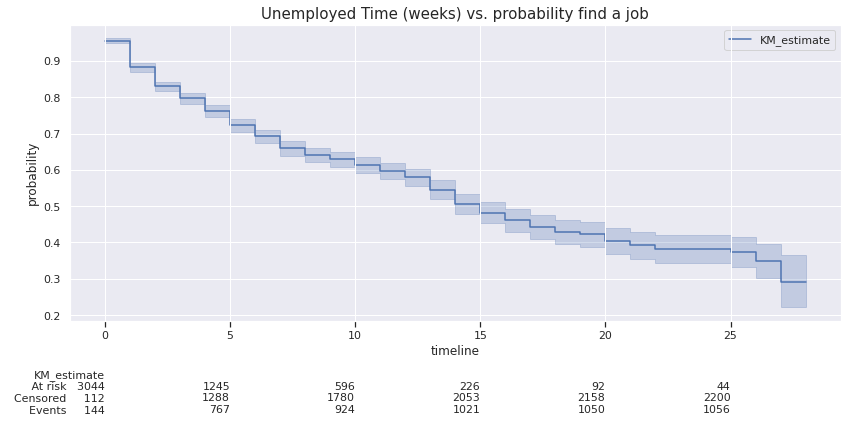

In [ ]:
# Kaplan-Meier plot
kmf = KaplanMeierFitter()
T = unempl_data['weeks']
C = unempl_data['event']
kmf.fit(T,C);

fig, ax = plt.subplots(figsize=(12,6))
kmf.plot(at_risk_counts=True)
plt.title('Unemployed Time (weeks) vs. probability find a job', fontsize=15)
ax.set_ylabel('probability')
ax.grid(b=True)

From the plot, we see that probability at time zero is almost 1.0, and it appears that not 100% of the participants were unemloyed at time zero. The column "event" indicates that some of the partisipants were employed at week 0. We see that 3,044 out of 3,300 participants are "at risk" (112 were censored and 144 found a job). We will assume that all were unemployed at the start, and censoring and event occured right after the start.

The median time it takes for individual to find a job is the point in time in which on average 50% of individuals have found a job.   
From plot observation we see that the median is 15 weeks of search.  

In [ ]:
# to check if our observed estimation is correct
kmf.median_survival_time_

15.0

### Step 2

Some say that married folks have an easier time finding work.  Create a Kaplan-Meier plot and interpret the difference in duration (which group and by how many weeks) for the first 25% that find work.

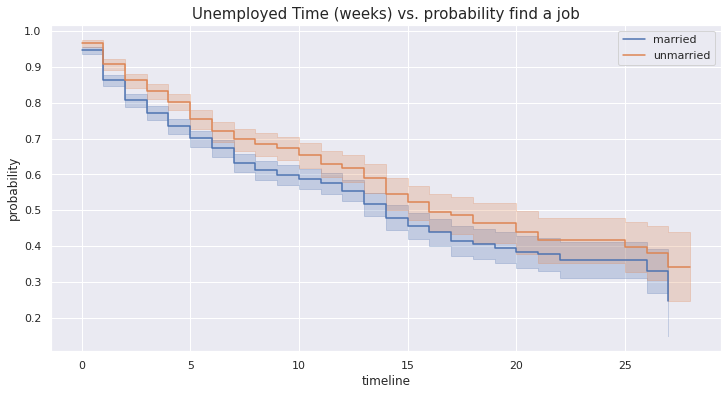

In [ ]:
#Breaking it down by Married/Unmarried
fig, ax = plt.subplots(figsize=(12,6))

labels = ['married','unmarried'] # maried=1, unmarried=0
tick_spacing = 0.1

plt.title('Unemployed Time (weeks) vs. probability find a job', fontsize=15)
ax.set_ylabel('probability')
for r in unempl_data['married'].unique():
    ix = unempl_data[unempl_data['married']==r].index
    kmf.fit(T[ix], C[ix], label=labels[r-1])
    kmf.plot(ax=ax)

ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.grid(b=True)

As we assumed that no one was employed at the start, our checkpoint roughly at 75% as it's 25% from the starting point.   
Difference in duration for the first 25% that find a job for each group:
married - about 4 weeks, unmarried - about 6 weeks.

### Step 3 Cox PH Model

Iterate on the Cox Proportional Hazards Model to identify the set of features (age, logsalary, married, isfemale, hasChildren, caucasian).


In [ ]:
cph = CoxPHFitter()
cph.fit(unempl_data, duration_col='weeks', event_col='event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3300 total observations, 2238 right-censored observations>
             duration col = 'weeks'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3300
number of events observed = 1062
   partial log-likelihood = -7793.61
         time fit was run = 2021-11-01 21:03:04 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age          -0.02       0.98       0.00            -0.03            -0.01                 0.97                 0.99
logsalary     0.30       1.35       0.06             0.18             0.42                 1.20                 1.53
married       0.28       1.32       0.07             0.13             0.42                 1.14                 1.53
isfemale      0.11       1.11       0.07            -0.03             0.24                 0.98                 1.27
hasChildren  -0.08       0.93       0.07            -0.21             0.06                 0.81                 1.06
caucasian     0.58       1.79       0.11             0.37             0.80                 1.44                 2.22

                z      p   -log2(p)
covariate                          
age         -6.17 <0.005      30.46
logsalary    4.82 <0.005      19.41
married      3.76 <0.005      12.54
isfemale     1.59   0.11       3.16
hasChildren -1.10   0.27       1.89
caucasian    5.32 <0.005      23.20
---
Concordance = 0.59
Partial AIC = 15599.21
log-likelihood ratio test = 107.37 on 6 df
-log2(p) of ll-ratio test = 66.91

We see that "isfemale" and "hasChildren" have very large p-values (>0.05), that inicates their statistical insignificance. We will remove feature with the largest p-value.

In [ ]:
features = ['weeks', 'event', 'age', 'logsalary', 'isfemale', 'married',  'caucasian'] #  'hasChildren' removed
cph2 = CoxPHFitter()
cph2.fit(unempl_data[features], duration_col='weeks', event_col='event')
cph2.params_

covariate
age         -0.019090
logsalary    0.301381
isfemale     0.106014
married      0.241920
caucasian    0.592136
Name: coef, dtype: float64

We see that coeficients got ajusted, that means the effect of the change in each feature will have a slightly different affect on the outcome.

In [ ]:
features = ['weeks', 'event', 'age', 'logsalary',  'married',  'caucasian'] #  'isfemale' removed
cph3 = CoxPHFitter()
cph3.fit(unempl_data[features], duration_col='weeks', event_col='event')
cph3.print_summary()

<lifelines.CoxPHFitter: fitted with 3300 total observations, 2238 right-censored observations>
             duration col = 'weeks'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3300
number of events observed = 1062
   partial log-likelihood = -7795.42
         time fit was run = 2021-11-01 21:16:26 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age        -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
logsalary   0.27       1.31       0.06             0.16             0.39                 1.17                 1.48
married     0.24       1.27       0.07             0.11             0.37                 1.11                 1.45
caucasian   0.59       1.81       0.11             0.38             0.81                 1.46                 2.24

              z      p   -log2(p)
covariate                        
age       -5.96 <0.005      28.52
logsalary  4.58 <0.005      17.70
married    3.59 <0.005      11.58
caucasian  5.44 <0.005      24.14
---
Concordance = 0.59
Partial AIC = 15598.84
log-likelihood ratio test = 103.74 on 4 df
-log2(p) of ll-ratio test = 69.11

We see that all features are statistically significant for the model.   
Fr example, "age" has a coefficient of -0.02. it the least significant feature. A one unit (1 year) increase in this factor means the the baseline hazard will decrease by a factor of exp(-0.2)=0.98 - about a 2% decrease. Cox proportional hazard model, a higher hazard means more at risk of the event occurring.

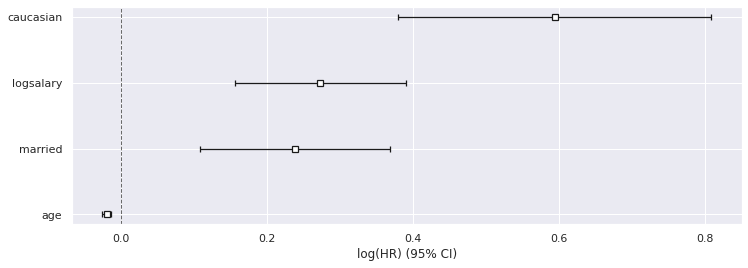

In [ ]:
fig, ax = plt.subplots(figsize=(12,4));
cph.plot(ax=ax)
plt.show()

### Ste 3 Examination of the results

#### Which feature has the most impact on the predicted duration?

The most significant feature is "caucasian" factor (whether the subject is caucasian or not). The values in the "caucasian" are binary: 0 or 1. The value of the coefficient associated with "caucasian", exp(0.59), is the value of ratio of hazards associated with being "caucasian", that is:  
$$
exp(0.59)= \frac{hazard\ of\ caucasian\ subjects\ at\ time\ t}{hazard\ of\ not caucasian\ subjects\ at\ time\ t}$$  
that is exp(0.59) = 1.8 - or about the baseline hazard will increase by about 80%, if partisipant is caucasian.

In [ ]:
cph3.params_

covariate
age         -0.018735
logsalary    0.273023
married      0.238326
caucasian    0.593780
Name: coef, dtype: float64

#### How much does this feature change the predicted duration of unemployment?

by about 80% (exp(0.59)=1.8) the duartion to fins a job (from the base hazard) will be decreased if a person is identified as caucasian.   
A higher hazard means more at risk of the event occurring.

#### Does it increase or decrease the predicted duration?

It has higher risk of event (employment) to be occure, which decrese the duration of unemployment.